In [1]:
import yfinance as yf
import os
import pandas as pd

# Fetching Bitcoin Data using Yahoo Finance API

In [2]:
btc_ticker = yf.Ticker("BTC-USD")

In [3]:
# Get Bitcoin historical data
btc = btc_ticker.history(period='max')

In [4]:
btc.index = pd.to_datetime(btc.index)

In [5]:
# Remove dividends and stock splits
del btc['Dividends']
del btc['Stock Splits']

In [6]:
# Lower case for the column names
btc.columns = [c.lower() for c in btc.columns]

<Axes: xlabel='Date'>

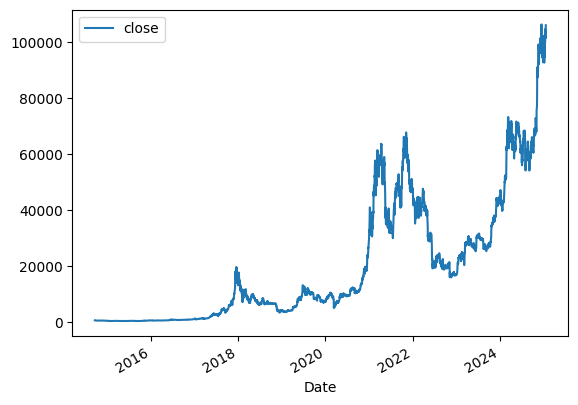

In [7]:
btc.plot.line(y="close", use_index=True)

In [9]:
wiki = pd.read_csv('/content/wikipedia_edits.csv',index_col=0, parse_dates=True)

In [10]:
btc.index = btc.index.date

btc = btc.merge(wiki, left_index=True, right_index=True)

In [11]:
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0.833333,-0.122828,0.466667
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0.833333,-0.123633,0.466667
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0.866667,-0.098696,0.466667
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.866667,-0.092632,0.466667
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0.866667,-0.034374,0.433333
...,...,...,...,...,...,...,...,...
2024-09-19,61651.156250,63872.441406,61609.867188,62940.457031,42710252573,0.033333,0.024937,0.000000
2024-09-20,62941.425781,64119.531250,62364.605469,63192.976562,35177164222,0.033333,0.024937,0.000000
2024-09-21,63184.339844,63543.359375,62783.105469,63394.839844,14408616220,0.033333,0.024937,0.000000
2024-09-22,63396.804688,63993.421875,62440.726562,63648.710938,20183348802,0.066667,-0.008386,0.033333


# Feature Engineering

In [12]:
# Create tomorrow column by using next day close value
btc["tomorrow"] = btc["close"].shift(-1)
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0.833333,-0.122828,0.466667,424.440002
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0.833333,-0.123633,0.466667,394.795990
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0.866667,-0.098696,0.466667,408.903992
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.866667,-0.092632,0.466667,398.821014
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0.866667,-0.034374,0.433333,402.152008
...,...,...,...,...,...,...,...,...,...
2024-09-19,61651.156250,63872.441406,61609.867188,62940.457031,42710252573,0.033333,0.024937,0.000000,63192.976562
2024-09-20,62941.425781,64119.531250,62364.605469,63192.976562,35177164222,0.033333,0.024937,0.000000,63394.839844
2024-09-21,63184.339844,63543.359375,62783.105469,63394.839844,14408616220,0.033333,0.024937,0.000000,63648.710938
2024-09-22,63396.804688,63993.421875,62440.726562,63648.710938,20183348802,0.066667,-0.008386,0.033333,63329.800781


In [13]:
# Create target column by compare tomorrow and close values
btc['target'] = (btc["tomorrow"] > btc["close"]).astype(int)

In [14]:
btc["target"].value_counts()

,count
target,
1,1934
0,1726


# Train model

In [15]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = btc.iloc[:-200]
test = btc[-200:]

predictors = ["close", "volume", "open", "high", "low", "edit_count", "sentiment", "neg_sentiment"]
model.fit(train[predictors], train["target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [16]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["target"], preds)

0.6071428571428571

# Evaluating error with backtest

In [17]:
def predict(train, test, predictors, model):
  model.fit(train[predictors], train["target"])
  preds = model.predict(test[predictors])
  preds = pd.Series(preds, index=test.index, name="predictions")
  combined = pd.concat([test["target"], preds], axis=1)
  return combined

In [18]:
def backtest(data, model, predictors, start=1095, step=150):
  all_predictions = []

  for i in range (start, data.shape[0], step):
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    predictions = predict(train, test, predictors, model)
    all_predictions.append(predictions)

  return pd.concat(all_predictions)

In [19]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state= 1, learning_rate=.2, n_estimators=200)
predictions = backtest(btc, model, predictors)

In [20]:
precision_score(predictions['target'], predictions["predictions"])

0.5148936170212766

# Improve precision

In [21]:
def compute_rolling(btc):
  horizons = [2, 7, 60, 365]
  new_predictors = ["close", "sentiment", "neg_sentiment"]

  for horizon in horizons:
    rolling_averages = btc.rolling(horizon, min_periods=1).mean()

    ratio_column = f'close_ratio_{horizon}'
    btc[ratio_column] = btc["close"] / rolling_averages["close"]

    edit_column = f'edit_{horizon}'
    btc[edit_column] = rolling_averages["edit_count"]

    rolling = btc.rolling(horizon, closed= "left", min_periods=1).mean()
    trend_column = f'trend_{horizon}'
    btc[trend_column] = rolling["target"]

    new_predictors += [ratio_column, trend_column, edit_column]

  return btc, new_predictors

In [22]:
btc, new_predictors = compute_rolling(btc.copy())

In [23]:
btc

,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target,...,trend_2,close_ratio_7,edit_7,trend_7,close_ratio_60,edit_60,trend_60,close_ratio_365,edit_365,trend_365
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0.833333,-0.122828,0.466667,424.440002,0,...,NaN,1.000000,0.833333,NaN,1.000000,0.833333,NaN,1.000000,0.833333,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0.833333,-0.123633,0.466667,394.795990,0,...,0.0,0.962696,0.833333,0.000000,0.962696,0.833333,0.000000,0.962696,0.833333,0.000000
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0.866667,-0.098696,0.466667,408.903992,1,...,0.0,0.927789,0.844444,0.000000,0.927789,0.844444,0.000000,0.927789,0.844444,0.000000
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0.866667,-0.092632,0.466667,398.821014,0,...,0.5,0.970419,0.850000,0.333333,0.970419,0.850000,0.333333,0.970419,0.850000,0.333333
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0.866667,-0.034374,0.433333,402.152008,1,...,0.5,0.956729,0.853333,0.250000,0.956729,0.853333,0.250000,0.956729,0.853333,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-19,61651.156250,63872.441406,61609.867188,62940.457031,42710252573,0.033333,0.024937,0.000000,63192.976562,1,...,1.0,1.041936,0.090476,0.571429,1.040980,0.196667,0.466667,1.186279,0.250594,0.523288
2024-09-20,62941.425781,64119.531250,62364.605469,63192.976562,35177164222,0.033333,0.024937,0.000000,63394.839844,1,...,1.0,1.039671,0.076190,0.571429,1.046424,0.195000,0.483333,1.188790,0.249863,0.526027
2024-09-21,63184.339844,63543.359375,62783.105469,63394.839844,14408616220,0.033333,0.024937,0.000000,63648.710938,1,...,1.0,1.034748,0.066667,0.714286,1.050501,0.193333,0.500000,1.190329,0.249041,0.526027
2024-09-22,63396.804688,63993.421875,62440.726562,63648.710938,20183348802,0.066667,-0.008386,0.033333,63329.800781,0,...,1.0,1.028185,0.061905,0.857143,1.055210,0.192222,0.516667,1.192821,0.248402,0.528767


In [24]:
btc = btc.dropna()

In [25]:
# Apply backtest function
predictions= backtest(btc, model, new_predictors)

In [26]:
precision_score(predictions['target'], predictions["predictions"])

0.5270727580372251

In [27]:
predictions

,target,predictions
2017-09-17,1,0
2017-09-18,0,1
2017-09-19,0,1
2017-09-20,0,1
2017-09-21,0,0
...,...,...
2024-09-18,1,0
2024-09-19,1,0
2024-09-20,1,0
2024-09-21,1,0
